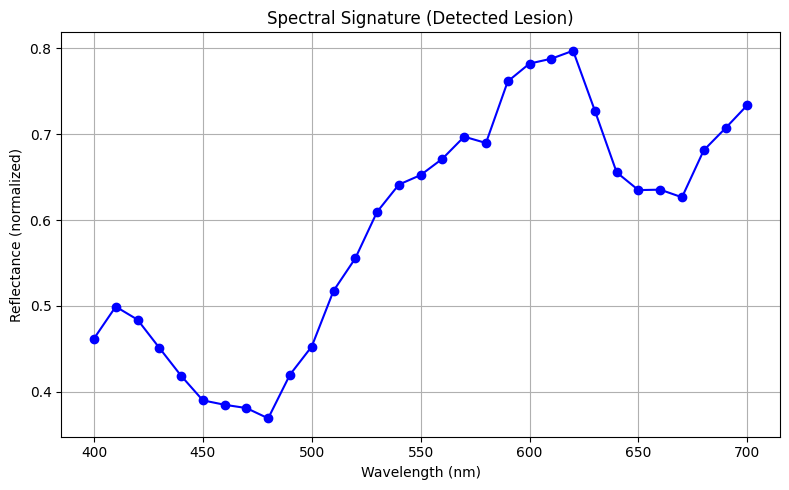

In [ ]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import cv2
from glob import glob

# === Path to HSI .mat files (e.g., melanoma class) ===
mat_path = "/content/drive/MyDrive/Colab Notebooks/MAIN_PROJECT/converted_hyperspectral_images/train/melanoma"
mat_files = sorted(glob(os.path.join(mat_path, "*.mat")))

# === Step 1: Load one .mat file ===
mat = sio.loadmat(mat_files[0])
hsi = mat['hyperspectral_image']  # shape: [31, 256, 256]

# === Step 2: Generate synthetic RGB from HSI bands (approx R, G, B)
rgb_bands = [10, 20, 30]  # Adjust as needed
rgb = np.stack([hsi[b] for b in rgb_bands], axis=-1)
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # Normalize to [0, 1]
rgb_uint8 = (rgb * 255).astype(np.uint8)

# === Step 3: Lesion detection via thresholding on grayscale
gray = cv2.cvtColor(rgb_uint8, cv2.COLOR_RGB2GRAY)
_, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))

# Extract largest connected component (likely lesion)
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
lesion_mask = (labels == largest_label)

# === Step 4: Extract spectral signature from lesion
lesion_pixels = hsi[:, lesion_mask]  # [31, N]
spectrum = lesion_pixels.mean(axis=1)  # [31]

# === Step 5: Plot spectral signature
wavelengths = np.linspace(400, 700, 31)

plt.figure(figsize=(8, 5))
plt.plot(wavelengths, spectrum, marker='o', color='blue')
plt.title("Spectral Signature (Detected Lesion)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance (normalized)")
plt.grid(True)
plt.tight_layout()
plt.show()


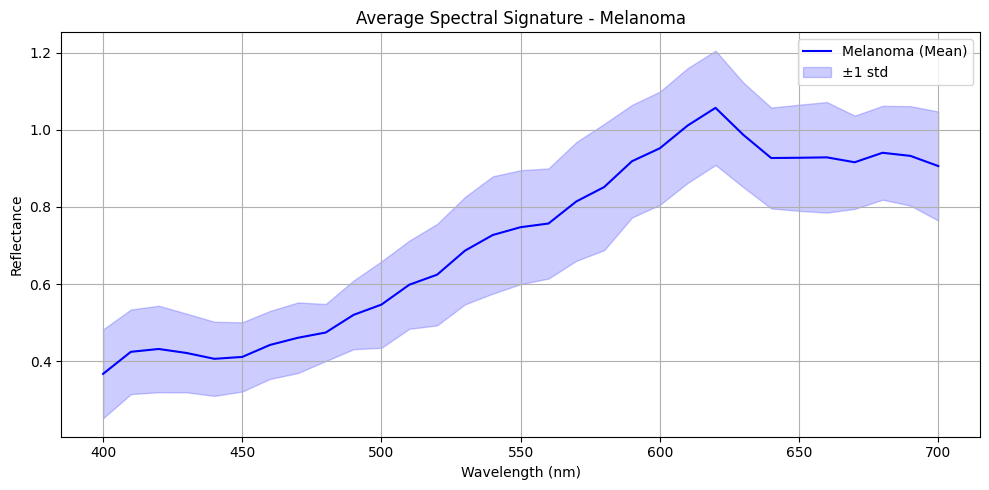

In [ ]:
all_spectra = []

for file in sorted(glob(os.path.join(mat_path, "*.mat"))):
    mat = sio.loadmat(file)
    hsi = mat['hyperspectral_image']  # [31, 256, 256]

    # Generate synthetic RGB from 3 bands
    rgb_bands = [10, 20, 30]
    rgb = np.stack([hsi[b] for b in rgb_bands], axis=-1)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
    rgb_uint8 = (rgb * 255).astype(np.uint8)

    # Lesion segmentation (thresholding)
    gray = cv2.cvtColor(rgb_uint8, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    lesion_mask = (labels == largest_label)

    # Extract lesion spectrum
    lesion_pixels = hsi[:, lesion_mask]
    if lesion_pixels.size == 0: continue  # skip if no lesion found
    spectrum = lesion_pixels.mean(axis=1)
    all_spectra.append(spectrum)

# Average all spectra
all_spectra = np.array(all_spectra)  # shape: [N, 31]
mean_spectrum = all_spectra.mean(axis=0)
std_spectrum = all_spectra.std(axis=0)

# Plot
wavelengths = np.linspace(400, 700, 31)

plt.figure(figsize=(10, 5))
plt.plot(wavelengths, mean_spectrum, label='Melanoma (Mean)', color='blue')
plt.fill_between(wavelengths, mean_spectrum - std_spectrum, mean_spectrum + std_spectrum,
                 color='blue', alpha=0.2, label='±1 std')
plt.title("Average Spectral Signature - Melanoma")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Processing class: actinic_keratosis


100%|██████████| 400/400 [01:16<00:00,  5.24it/s]


Processing class: bcc


100%|██████████| 400/400 [00:57<00:00,  6.94it/s]


Processing class: dermatofibroma


100%|██████████| 400/400 [00:53<00:00,  7.45it/s]


Processing class: melanoma


100%|██████████| 438/438 [00:13<00:00, 31.67it/s]


Processing class: nevus


100%|██████████| 400/400 [01:07<00:00,  5.95it/s]


Processing class: pigmented_benign_keratosis


100%|██████████| 464/464 [01:10<00:00,  6.56it/s]


Processing class: scc


100%|██████████| 400/400 [00:51<00:00,  7.76it/s]


Processing class: seborrheic_keratosis


100%|██████████| 400/400 [00:52<00:00,  7.61it/s]


Processing class: vascular_lesion


100%|██████████| 400/400 [00:37<00:00, 10.67it/s]


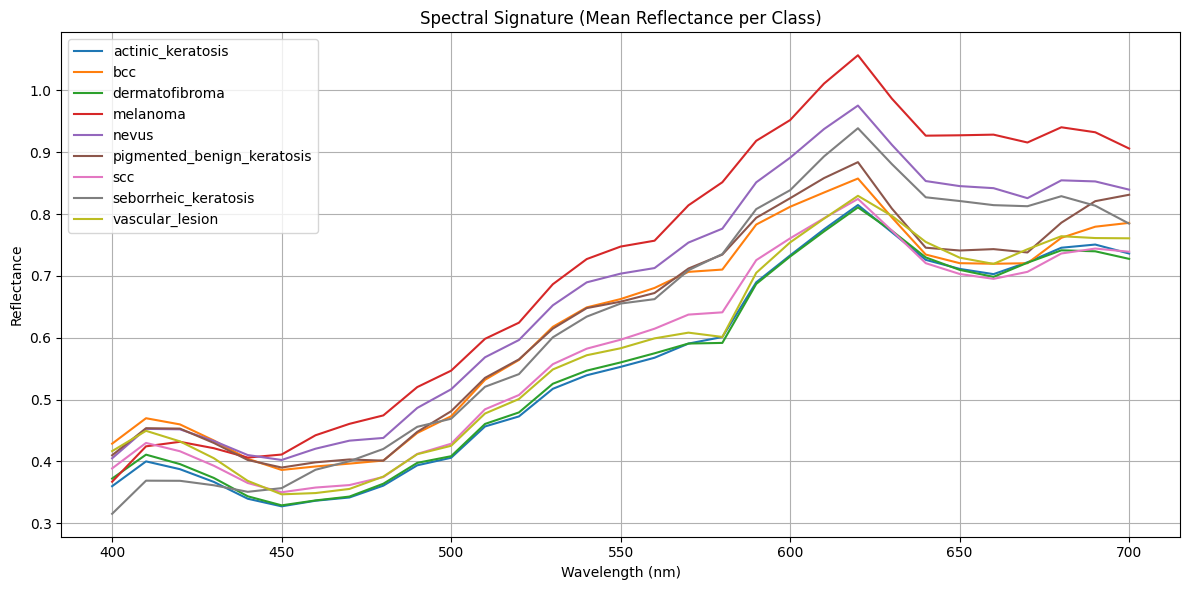

,Class,Wavelength (nm),Mean Reflectance,Std Reflectance
0,actinic_keratosis,400.0,0.359895,0.105147
1,actinic_keratosis,410.0,0.400028,0.095556
2,actinic_keratosis,420.0,0.387421,0.093343
3,actinic_keratosis,430.0,0.366839,0.083887
4,actinic_keratosis,440.0,0.339638,0.075594
5,actinic_keratosis,450.0,0.327328,0.070260
6,actinic_keratosis,460.0,0.336419,0.067371
7,actinic_keratosis,470.0,0.341651,0.067578
8,actinic_keratosis,480.0,0.360816,0.055405
9,actinic_keratosis,490.0,0.393673,0.064202


In [ ]:
# Re-import all necessary modules after code execution environment reset
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm

# === Configuration ===
base_path = "/content/drive/MyDrive/Colab Notebooks/MAIN_PROJECT/converted_hyperspectral_images/train"
classes = sorted(os.listdir(base_path))
wavelengths = np.linspace(400, 700, 31)

# === Storage ===
class_mean_spectra = {}
class_std_spectra = {}
spectral_table_data = []

# === Loop through all classes ===
for cls in classes:
    print(f"Processing class: {cls}")
    mat_files = sorted(glob(os.path.join(base_path, cls, "*.mat")))
    all_spectra = []

    for file in tqdm(mat_files):
        mat = sio.loadmat(file)
        if 'hyperspectral_image' not in mat:
            continue
        hsi = mat['hyperspectral_image']  # [31, 256, 256]

        # Create synthetic RGB image
        rgb = np.stack([hsi[10], hsi[20], hsi[30]], axis=-1)
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
        rgb_uint8 = (rgb * 255).astype(np.uint8)

        # Lesion segmentation (Otsu on grayscale)
        gray = cv2.cvtColor(rgb_uint8, cv2.COLOR_RGB2GRAY)
        _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
        if num_labels <= 1:
            continue
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        lesion_mask = (labels == largest_label)

        lesion_pixels = hsi[:, lesion_mask]
        if lesion_pixels.size == 0:
            continue
        spectrum = lesion_pixels.mean(axis=1)
        all_spectra.append(spectrum)

    # Compute class mean and std
    if not all_spectra:
        continue

    all_spectra = np.array(all_spectra)
    class_mean = all_spectra.mean(axis=0)
    class_std = all_spectra.std(axis=0)

    class_mean_spectra[cls] = class_mean
    class_std_spectra[cls] = class_std

    for i in range(31):
        spectral_table_data.append({
            "Class": cls,
            "Wavelength (nm)": round(wavelengths[i], 1),
            "Mean Reflectance": class_mean[i],
            "Std Reflectance": class_std[i]
        })

# === Visualization: Spectral curves for all classes ===
plt.figure(figsize=(12, 6))
for cls in classes:
    if cls in class_mean_spectra:
        plt.plot(wavelengths, class_mean_spectra[cls], label=cls)
plt.title("Spectral Signature (Mean Reflectance per Class)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Output: Spectral Table ===
spectral_df = pd.DataFrame(spectral_table_data)
spectral_df_sorted = spectral_df.sort_values(by=["Class", "Wavelength (nm)"])
spectral_df_sorted.reset_index(drop=True, inplace=True)
spectral_df_sorted.head(10)  # Display first 10 rows of the table


In [ ]:
# === Output: Spectral Table ===
spectral_df = pd.DataFrame(spectral_table_data)
spectral_df_sorted = spectral_df.sort_values(by=["Class", "Wavelength (nm)"])
spectral_df_sorted.reset_index(drop=True, inplace=True)
spectral_df_sorted.head(400)  # Display first 10 rows of the table

,Class,Wavelength (nm),Mean Reflectance,Std Reflectance
0,actinic_keratosis,400.0,0.359895,0.105147
1,actinic_keratosis,410.0,0.400028,0.095556
2,actinic_keratosis,420.0,0.387421,0.093343
3,actinic_keratosis,430.0,0.366839,0.083887
4,actinic_keratosis,440.0,0.339638,0.075594
...,...,...,...,...
274,vascular_lesion,660.0,0.719465,0.091674
275,vascular_lesion,670.0,0.743175,0.082476
276,vascular_lesion,680.0,0.764247,0.083357
277,vascular_lesion,690.0,0.761280,0.093599


In [ ]:
# Save the existing spectral table as a CSV file
spectral_df_sorted.to_csv('spectral_data.csv', index=False)

# Display a sample of rows from each class (first row for each class) for verification
sample_df = spectral_df_sorted.groupby('Class').first().reset_index()
print(sample_df)

                        Class  Wavelength (nm)  Mean Reflectance  \
0           actinic_keratosis            400.0          0.359895   
1                         bcc            400.0          0.428681   
2              dermatofibroma            400.0          0.372259   
3                    melanoma            400.0          0.367127   
4                       nevus            400.0          0.405028   
5  pigmented_benign_keratosis            400.0          0.409891   
6                         scc            400.0          0.388658   
7        seborrheic_keratosis            400.0          0.315262   
8             vascular_lesion            400.0          0.416636   

   Std Reflectance  
0         0.105147  
1         0.095307  
2         0.113284  
3         0.115249  
4         0.128645  
5         0.081505  
6         0.097148  
7         0.124980  
8         0.090350  


In [ ]:
import os
import numpy as np
import scipy.io as sio
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm

# === Define data path ===
data_path = "/content/drive/MyDrive/Colab Notebooks/MAIN_PROJECT/converted_hyperspectral_images/train"
classes = sorted(os.listdir(data_path))
wavelengths = [f"W{int(w)}" for w in np.linspace(400, 700, 31)]

# === Prepare dataset ===
records = []

for cls in classes:
    class_path = os.path.join(data_path, cls)
    mat_files = sorted(glob(os.path.join(class_path, "*.mat")))
    for file in tqdm(mat_files, desc=f"Processing {cls}"):
        mat = sio.loadmat(file)
        if 'hyperspectral_image' not in mat:
            continue
        hsi = mat['hyperspectral_image']  # [31, 256, 256]

        # Create RGB to find lesion
        rgb = np.stack([hsi[10], hsi[20], hsi[30]], axis=-1)
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
        rgb_uint8 = (rgb * 255).astype(np.uint8)

        # Segment lesion using Otsu
        gray = cv2.cvtColor(rgb_uint8, cv2.COLOR_RGB2GRAY)
        _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))

        # Largest connected component
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
        if num_labels <= 1:
            continue
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        lesion_mask = (labels == largest_label)

        lesion_pixels = hsi[:, lesion_mask]
        if lesion_pixels.size == 0:
            continue
        spectrum = lesion_pixels.mean(axis=1)

        row = {"Image": os.path.basename(file), "Class": cls}
        row.update({wavelengths[i]: spectrum[i] for i in range(31)})
        records.append(row)

# === Save to DataFrame ===
df_spectral_samples = pd.DataFrame(records)
df_spectral_samples.head()


Processing vascular_lesion: 100%|██████████| 400/400 [00:29<00:00, 13.77it/s]


,Image,Class,W400,W410,W420,W430,W440,W450,W460,W470,...,W610,W620,W630,W640,W650,W660,W670,W680,W690,W700
0,actinic_keratosis_aug_0.mat,actinic_keratosis,0.259285,0.305908,0.306407,0.302673,0.297135,0.303842,0.324851,0.327816,...,0.730415,0.772478,0.704523,0.653442,0.656214,0.644206,0.625257,0.648235,0.672217,0.643759
1,actinic_keratosis_aug_1.mat,actinic_keratosis,0.398432,0.443152,0.416671,0.388458,0.356568,0.337060,0.346079,0.349886,...,0.754272,0.776626,0.732518,0.677886,0.651641,0.639700,0.669758,0.700697,0.707334,0.712797
2,actinic_keratosis_aug_10.mat,actinic_keratosis,0.179951,0.234133,0.208981,0.201450,0.179556,0.183067,0.207031,0.216348,...,0.633778,0.702273,0.695281,0.678369,0.653935,0.623606,0.735036,0.724821,0.704595,0.634476
3,actinic_keratosis_aug_100.mat,actinic_keratosis,0.293828,0.333555,0.334019,0.317155,0.288162,0.278210,0.289014,0.298743,...,0.742729,0.803118,0.761333,0.729762,0.737473,0.743070,0.751196,0.773470,0.785723,0.758907
4,actinic_keratosis_aug_101.mat,actinic_keratosis,0.215382,0.282098,0.285223,0.289529,0.287506,0.314545,0.360948,0.377640,...,0.944625,1.012827,0.954974,0.910860,0.911246,0.895062,0.916721,0.900399,0.875626,0.794023


In [ ]:
# Save DataFrame to CSV
output_path = "/content/spectral_samples.csv"
df_spectral_samples.to_csv(output_path, index=False)

# Download the CSV file
from google.colab import files
files.download(output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

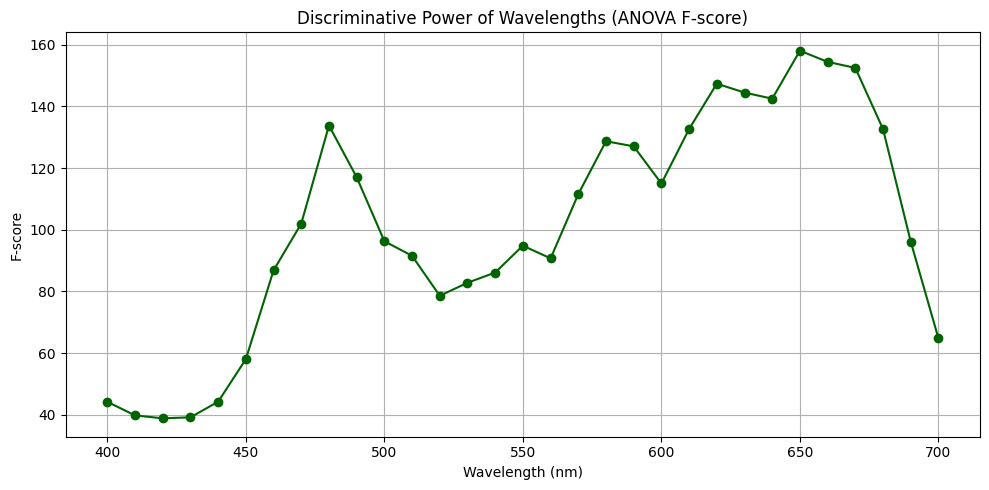

    Wavelength (nm)     F-score        p-value
25              650  158.080369  1.215054e-229
26              660  154.463144  5.710422e-225
27              670  152.501410  2.003284e-222
22              620  147.396351  9.169920e-216
23              630  144.492635  5.960830e-212
24              640  142.527706  2.320883e-209
8               480  133.810235  9.077713e-198
21              610  132.667171  3.092195e-196
28              680  132.645844  3.302815e-196
18              580  128.719660  6.369773e-191


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt

# Load your per-image spectral CSV
df = pd.read_csv("/content/spectral_samples.csv")  # adjust path if needed

# Prepare features and labels
X = df.drop(columns=["Image", "Class"]).values
y = LabelEncoder().fit_transform(df["Class"])

# Extract wavelength names
wavelengths = df.columns[2:].str.extract(r'(\d+)').astype(int).squeeze()

# Compute ANOVA F-scores
f_values, p_values = f_classif(X, y)

# Plot the F-scores
plt.figure(figsize=(10, 5))
plt.plot(wavelengths, f_values, marker='o', color='darkgreen')
plt.title("Discriminative Power of Wavelengths (ANOVA F-score)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("F-score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Show top 10 wavelengths
top_bands = pd.DataFrame({
    "Wavelength (nm)": wavelengths,
    "F-score": f_values,
    "p-value": p_values
}).sort_values(by="F-score", ascending=False)

print(top_bands.head(10))


Classification Report:
                             precision    recall  f1-score   support

         actinic_keratosis       0.18      0.23      0.20        80
                       bcc       0.31      0.34      0.33        80
            dermatofibroma       0.25      0.23      0.24        80
                  melanoma       0.51      0.47      0.49        88
                     nevus       0.33      0.28      0.30        80
pigmented_benign_keratosis       0.35      0.42      0.38        93
                       scc       0.21      0.17      0.19        80
      seborrheic_keratosis       0.40      0.46      0.43        80
           vascular_lesion       0.39      0.33      0.36        80

                  accuracy                           0.33       741
                 macro avg       0.33      0.32      0.32       741
              weighted avg       0.33      0.33      0.33       741



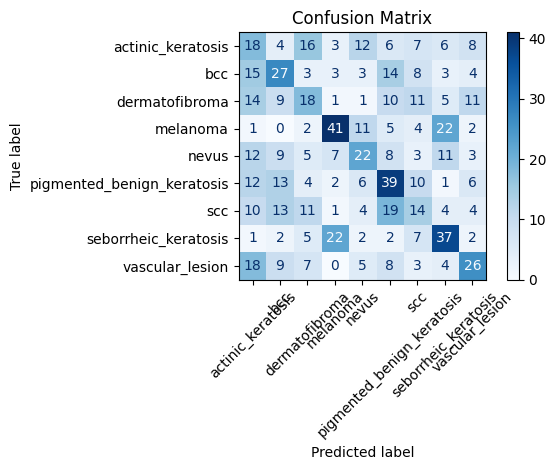

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/content/spectral_samples.csv")  # Update path if needed

# Prepare X and y
X = df.drop(columns=["Image", "Class"]).values
y = LabelEncoder().fit_transform(df["Class"])
class_names = sorted(df["Class"].unique())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)

# Metrics
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load your spectral reflectance CSV file
df = pd.read_csv("/content/spectral_samples.csv")  # change path as needed

# Identify spectral columns (e.g., W400 to W700)
wavelength_columns = [col for col in df.columns if col.startswith("W")]

# Compute mean reflectance for each class
mean_per_class = df.groupby("Class")[wavelength_columns].mean()

# Find the band with maximum reflectance for each class
best_wavelengths = []
for cls in mean_per_class.index:
    row = mean_per_class.loc[cls]
    best_band = row.idxmax()
    best_wavelength = int(best_band[1:])  # convert 'W620' → 620
    reflectance = row[best_band]
    best_wavelengths.append({
        "Class": cls,
        "Best Wavelength (nm)": best_wavelength,
        "Mean Reflectance": reflectance
    })

# Convert to DataFrame and save
df_best = pd.DataFrame(best_wavelengths)
df_best.to_csv("best_wavelength_per_class_from_data.csv", index=False)
print(df_best)


                        Class  Best Wavelength (nm)  Mean Reflectance
0           actinic_keratosis                   620          0.814725
1                         bcc                   620          0.857561
2              dermatofibroma                   620          0.810875
3                    melanoma                   620          1.056945
4                       nevus                   620          0.975585
5  pigmented_benign_keratosis                   620          0.884046
6                         scc                   620          0.824574
7        seborrheic_keratosis                   620          0.938904
8             vascular_lesion                   620          0.829602


In [ ]:
import pandas as pd
from sklearn.feature_selection import f_classif

# Load your CSV
df = pd.read_csv("/content/spectral_samples.csv")  # Adjust path

# Identify spectral band columns
wavelength_columns = [col for col in df.columns if col.startswith("W")]

# Features (X) and Labels (y)
X = df[wavelength_columns].values
y = df["Class"].values

# Compute ANOVA F-score
f_scores, p_values = f_classif(X, y)

# Create DataFrame of results
anova_df = pd.DataFrame({
    "Wavelength (nm)": [int(col[1:]) for col in wavelength_columns],
    "F-score": f_scores,
    "p-value": p_values
})

# Sort by F-score
anova_df_sorted = anova_df.sort_values(by="F-score", ascending=False)

# Save
anova_df_sorted.to_csv("anova_discriminative_wavelengths.csv", index=False)
print(anova_df_sorted.head(10))  # View top 10 bands


    Wavelength (nm)     F-score        p-value
25              650  158.080369  1.215054e-229
26              660  154.463144  5.710422e-225
27              670  152.501410  2.003284e-222
22              620  147.396351  9.169920e-216
23              630  144.492635  5.960830e-212
24              640  142.527706  2.320883e-209
8               480  133.810235  9.077713e-198
21              610  132.667171  3.092195e-196
28              680  132.645844  3.302815e-196
18              580  128.719660  6.369773e-191


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif

# Load your dataset
df = pd.read_csv("/content/spectral_samples.csv")  # adjust path

# Get list of wavelengths and classes
wavelength_columns = [col for col in df.columns if col.startswith("W")]
classes = df["Class"].unique()

results = []

# Loop through each class for one-vs-rest F-score
for target_class in classes:
    X = df[wavelength_columns].values
    y = np.where(df["Class"] == target_class, 1, 0)  # binary labels: 1 = class, 0 = rest

    f_scores, p_values = f_classif(X, y)

    # Get best wavelength for this class
    best_idx = np.argmax(f_scores)
    best_wave = int(wavelength_columns[best_idx][1:])
    best_fscore = f_scores[best_idx]

    results.append({
        "Class": target_class,
        "Best Wavelength (nm)": best_wave,
        "F-score": best_fscore
    })

# Save and show
df_best_per_class = pd.DataFrame(results)
df_best_per_class.to_csv("classwise_best_wavelengths.csv", index=False)
print(df_best_per_class)


                        Class  Best Wavelength (nm)     F-score
0           actinic_keratosis                   550  141.290013
1                         bcc                   400   69.849396
2              dermatofibroma                   580  150.157192
3                    melanoma                   670  718.660624
4                       nevus                   630  126.914850
5  pigmented_benign_keratosis                   420   42.582312
6                         scc                   670   97.715772
7        seborrheic_keratosis                   400  184.526674
8             vascular_lesion                   580  122.851633


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif

# Load your data
df = pd.read_csv("/content/spectral_samples.csv")  # adjust path

wavelength_columns = [col for col in df.columns if col.startswith("W")]
classes = df["Class"].unique()

records = []

# One-vs-rest F-score for each class
for cls in classes:
    X = df[wavelength_columns].values
    y = np.where(df["Class"] == cls, 1, 0)

    f_scores, p_vals = f_classif(X, y)

    # Get top 3 indices
    top_indices = np.argsort(f_scores)[-3:][::-1]

    for rank, idx in enumerate(top_indices, 1):
        records.append({
            "Class": cls,
            "Rank": rank,
            "Wavelength (nm)": int(wavelength_columns[idx][1:]),
            "F-score": f_scores[idx]
        })

# Save and show
df_top3 = pd.DataFrame(records)
df_top3.to_csv("top3_wavelengths_per_class.csv", index=False)
print(df_top3)


                         Class  Rank  Wavelength (nm)     F-score
0            actinic_keratosis     1              550  141.290013
1            actinic_keratosis     2              560  141.112513
2            actinic_keratosis     3              570  138.485216
3                          bcc     1              400   69.849396
4                          bcc     2              410   67.694965
5                          bcc     3              670   57.986841
6               dermatofibroma     1              580  150.157192
7               dermatofibroma     2              590  138.664465
8               dermatofibroma     3              570  138.258185
9                     melanoma     1              670  718.660624
10                    melanoma     2              650  669.309600
11                    melanoma     3              660  662.618348
12                       nevus     1              630  126.914850
13                       nevus     2              620  124.967780
14        

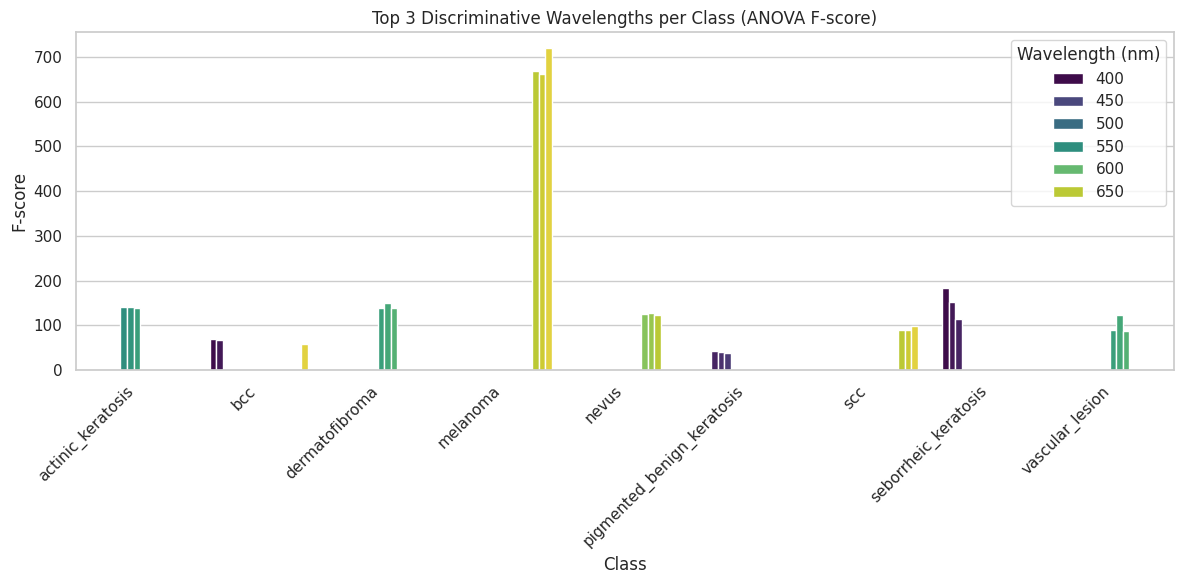

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV
df_top3 = pd.read_csv("/content/top3_wavelengths_per_class.csv")  # Adjust path if needed

# Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Create barplot
sns.barplot(data=df_top3, x="Class", y="F-score", hue="Wavelength (nm)", palette="viridis")

plt.title("Top 3 Discriminative Wavelengths per Class (ANOVA F-score)")
plt.ylabel("F-score")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Wavelength (nm)")
plt.tight_layout()
plt.savefig("top3_wavelengths_per_class_plot.png")
plt.show()


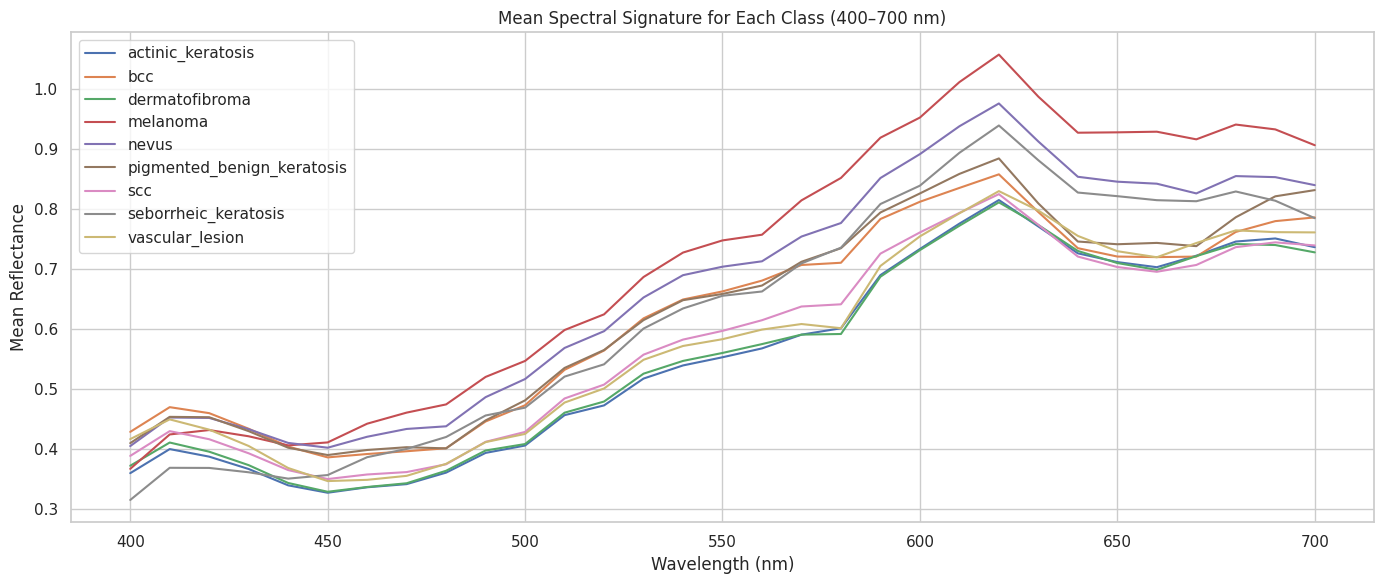

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
df = pd.read_csv("/content/spectral_samples.csv")  # adjust path

# Get spectral columns
wavelength_columns = [col for col in df.columns if col.startswith("W")]

# Compute mean reflectance per wavelength for each class
mean_signatures = df.groupby("Class")[wavelength_columns].mean().T

# Convert index to numeric wavelengths
mean_signatures.index = mean_signatures.index.str.replace("W", "").astype(int)

# Plot
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

for cls in mean_signatures.columns:
    plt.plot(mean_signatures.index, mean_signatures[cls], label=cls)

plt.title("Mean Spectral Signature for Each Class (400–700 nm)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Mean Reflectance")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.savefig("mean_spectral_signature_per_class.png")
plt.show()


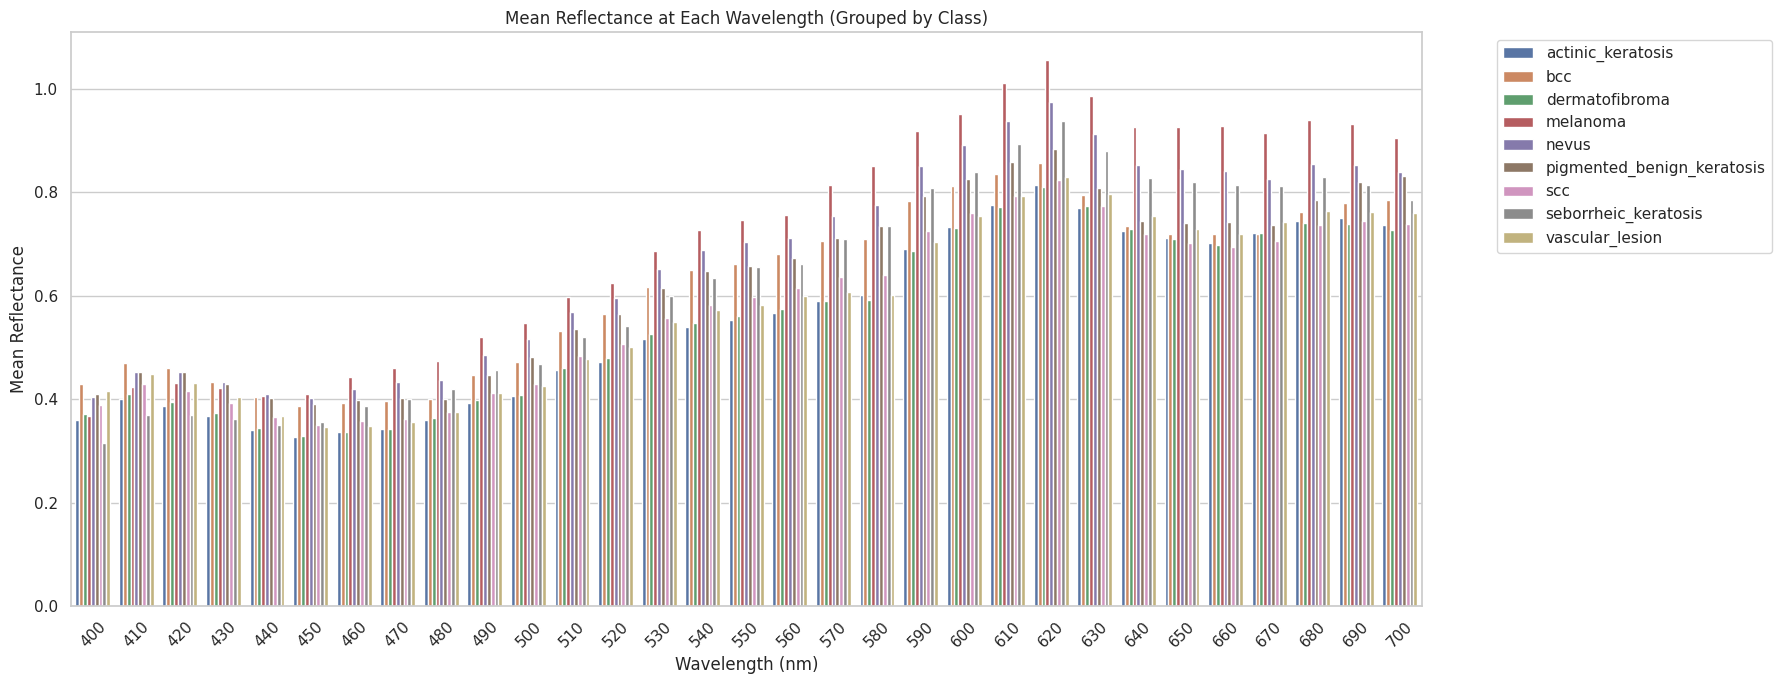

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv("/content/spectral_samples.csv")  # adjust path

# Extract spectral columns
wavelength_columns = [col for col in df.columns if col.startswith("W")]

# Compute mean reflectance per class
mean_per_class = df.groupby("Class")[wavelength_columns].mean()

# Melt into long format for seaborn barplot
df_melted = mean_per_class.reset_index().melt(id_vars="Class", var_name="Wavelength", value_name="Mean Reflectance")
df_melted["Wavelength"] = df_melted["Wavelength"].str.replace("W", "").astype(int)

# Plot
plt.figure(figsize=(18, 7))
sns.barplot(data=df_melted, x="Wavelength", y="Mean Reflectance", hue="Class")
plt.title("Mean Reflectance at Each Wavelength (Grouped by Class)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Mean Reflectance")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("spectral_barplot_all_classes.png")
plt.show()
